In [2]:
!unzip /content/online_retail_II.csv.zip

Archive:  /content/online_retail_II.csv.zip
  inflating: online_retail_II.csv    


In [29]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

In [30]:
# Load dataset
df = pd.read_csv("/content/online_retail_II.csv")

In [31]:
# View data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [32]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [33]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [34]:
# Check for NULL values
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [36]:
df['Country'].value_counts()

,count
Country,
United Kingdom,981330
EIRE,17866
Germany,17624
France,14330
Netherlands,5140
Spain,3811
Switzerland,3189
Belgium,3123
Portugal,2620


In [37]:
df['Invoice'].value_counts()

,count
Invoice,
537434,1350
538071,1304
537638,1202
537237,1194
536876,1186
...,...
514996,1
514995,1
C548605,1


In [38]:
# Data Description
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### Preprocessing

In [39]:
# Remove cancelled invoices
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [40]:
# Remove negative or zero prices and quantities
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [41]:
# Drop rows without CustomerID
df = df.dropna(subset=['Customer ID'])

In [42]:
# Remove non-product codes like POSTAGE, DISCOUNT
df = df[~df['Description'].str.contains('POSTAGE|DISCOUNT|ADJUSTMENT|M|DOTCOM', na=False)]

print("Rows after cleaning:", len(df))

Rows after cleaning: 468353


###  Feature Engineering

In [43]:
# Customer-Product matrix (binary purchases)
customer_product = pd.crosstab(df['Customer ID'], df['StockCode'])
print("Customer-Product matrix shape:", customer_product.shape)

Customer-Product matrix shape: (5773, 2703)


In [44]:
# Filter active customers (>=20 purchases) and popular products (>=50 purchases)
customer_product = customer_product.loc[customer_product.sum(axis=1) >= 20]
customer_product = customer_product.loc[:, customer_product.sum(axis=0) >= 50]
print("Filtered Customer-Product matrix shape:", customer_product.shape)

Filtered Customer-Product matrix shape: (3678, 1512)


In [60]:
# Sample subset for clustering
customer_sample = customer_product.sample(n=20000, random_state=42, axis=0) if customer_product.shape[0] > 20000 else customer_product
customer_sample = customer_sample.sample(n=5000, random_state=42, axis=1) if customer_sample.shape[1] > 5000 else customer_sample
print("Final sampled shape:", customer_sample.shape)

Final sampled shape: (3678, 1512)


In [61]:
# Normalize rows
X = normalize(customer_sample, norm="l2")

In [62]:
# Product-Product Similarity Matrix
# Co-occurrence similarity
product_similarity = np.dot(customer_sample.T, customer_sample)
print("Product-Product similarity shape:", product_similarity.shape)

Product-Product similarity shape: (1512, 1512)


In [63]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)

### Clustering

In [64]:
n_clusters = 6

In [65]:
# Spectral clustering
spectral_norm = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors",
                                   assign_labels="kmeans", random_state=42)
labels_spectral_norm = spectral_norm.fit_predict(X_reduced)

In [66]:
# Spectral clustering
spectral_unnorm = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors",
                                     assign_labels="discretize", random_state=42)
labels_spectral_unnorm = spectral_unnorm.fit_predict(X_reduced)

In [67]:
# Spectral clustering (kernel RBF)
spectral_rbf = SpectralClustering(n_clusters=n_clusters, affinity="rbf", random_state=42)
labels_spectral_rbf = spectral_rbf.fit_predict(X_reduced)

In [68]:
# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels_kmeans = kmeans.fit_predict(X_reduced)

In [69]:
# Agglomerative
agglo = AgglomerativeClustering(n_clusters=n_clusters)
labels_agglo = agglo.fit_predict(X_reduced)

### Evaluation

In [70]:
results = []

def evaluate(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    results.append([name, sil, db, ch, np.bincount(labels)])

evaluate(X_reduced, labels_spectral_norm, "Spectral (normalized)")
evaluate(X_reduced, labels_spectral_unnorm, "Spectral (unnormalized)")
evaluate(X_reduced, labels_spectral_rbf, "Spectral (RBF kernel)")
evaluate(X_reduced, labels_kmeans, "KMeans")
evaluate(X_reduced, labels_agglo, "Agglomerative")

In [71]:
# Show evaluation table
results_df = pd.DataFrame(results, columns=["Method","Silhouette","Davies-Bouldin","Calinski-Harabasz","Cluster sizes"])
print("Evaluation Results ")
results_df

Evaluation Results 


,Method,Silhouette,Davies-Bouldin,Calinski-Harabasz,Cluster sizes
0,Spectral (normalized),0.063211,2.494292,99.338841,"[2387, 232, 860, 24, 149, 26]"
1,Spectral (unnormalized),0.057276,3.020685,117.694094,"[983, 1780, 167, 365, 52, 331]"
2,Spectral (RBF kernel),0.053116,3.277074,151.164890,"[305, 705, 1259, 379, 532, 498]"
3,KMeans,0.052813,3.297612,154.562148,"[597, 395, 609, 1200, 394, 483]"
4,Agglomerative,0.037778,3.429835,104.946821,"[1001, 446, 1633, 245, 210, 143]"


### Visualization

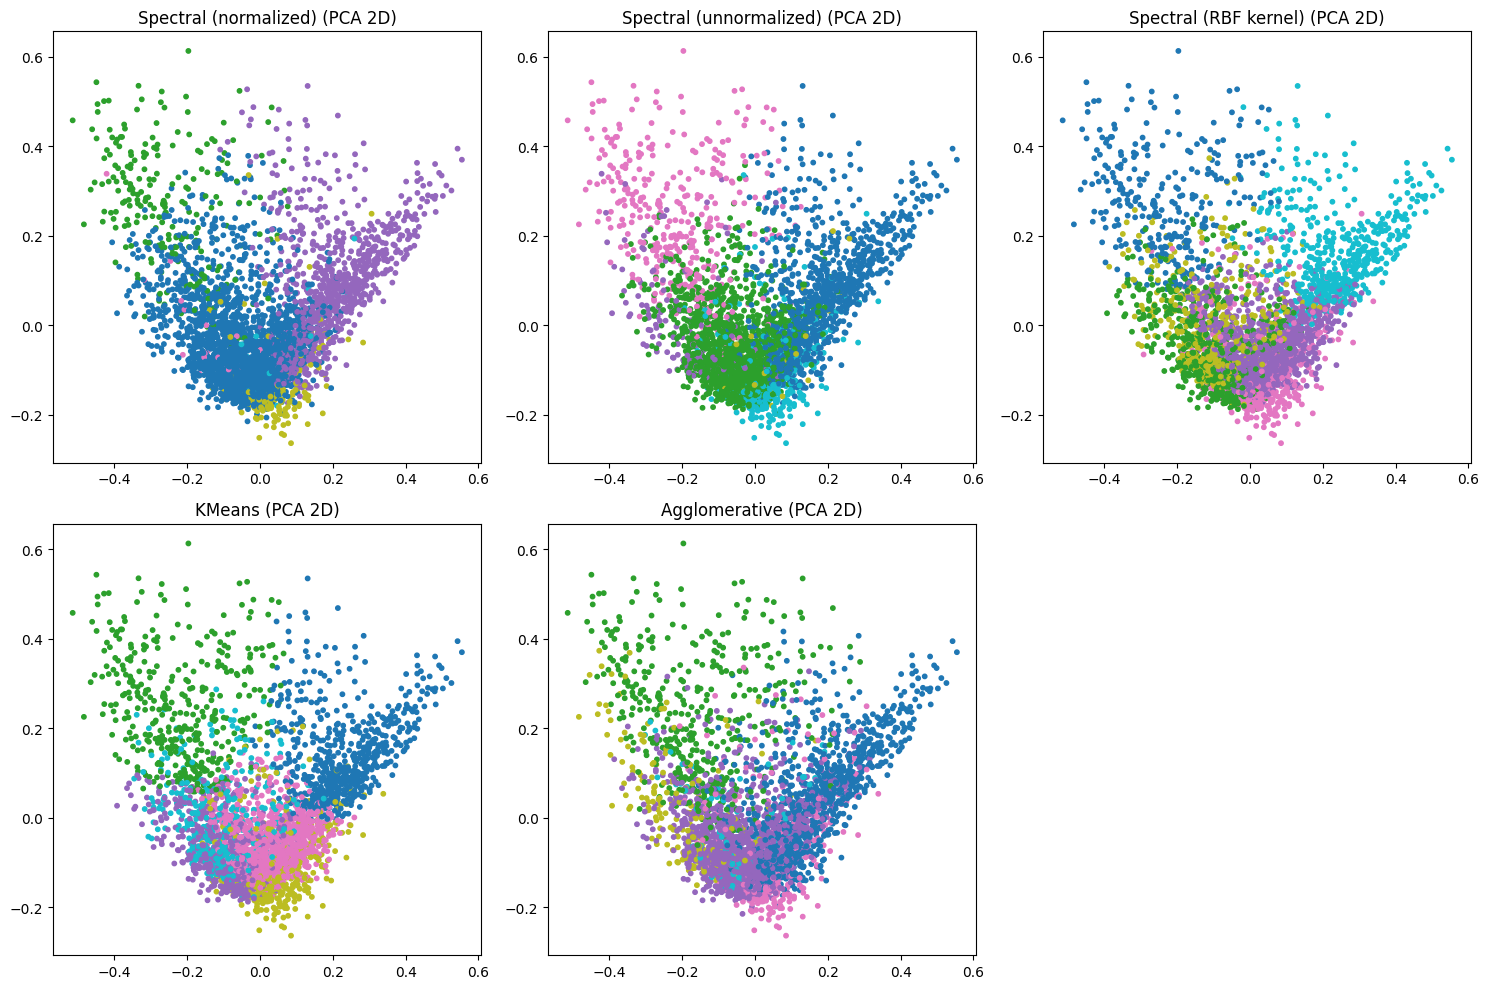

In [72]:
# PCA 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_reduced)

methods_labels = {
    "Spectral (normalized)": labels_spectral_norm,
    "Spectral (unnormalized)": labels_spectral_unnorm,
    "Spectral (RBF kernel)": labels_spectral_rbf,
    "KMeans": labels_kmeans,
    "Agglomerative": labels_agglo
}
plt.figure(figsize=(15,10))
for i, (name, labels) in enumerate(methods_labels.items(), 1):
    plt.subplot(2,3,i)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=10)
    plt.title(f"{name} (PCA 2D)")
plt.tight_layout()
plt.show()

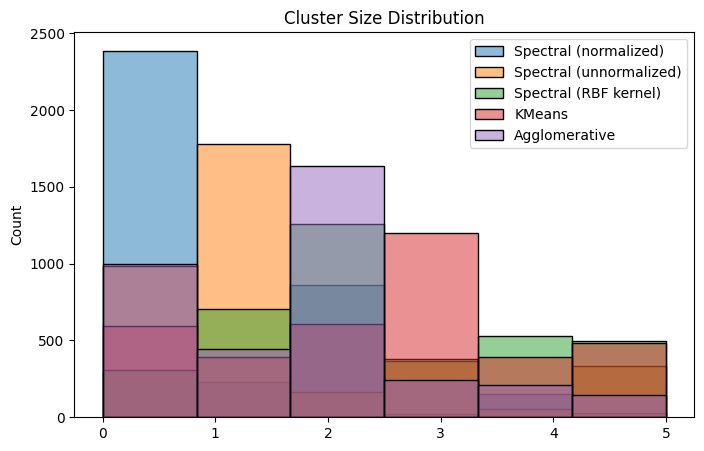

In [73]:
# Cluster size distribution
plt.figure(figsize=(8,5))
for name, labels in methods_labels.items():
    sns.histplot(labels, bins=n_clusters, stat="count", label=name, alpha=0.5)
plt.legend()
plt.title("Cluster Size Distribution")
plt.show()

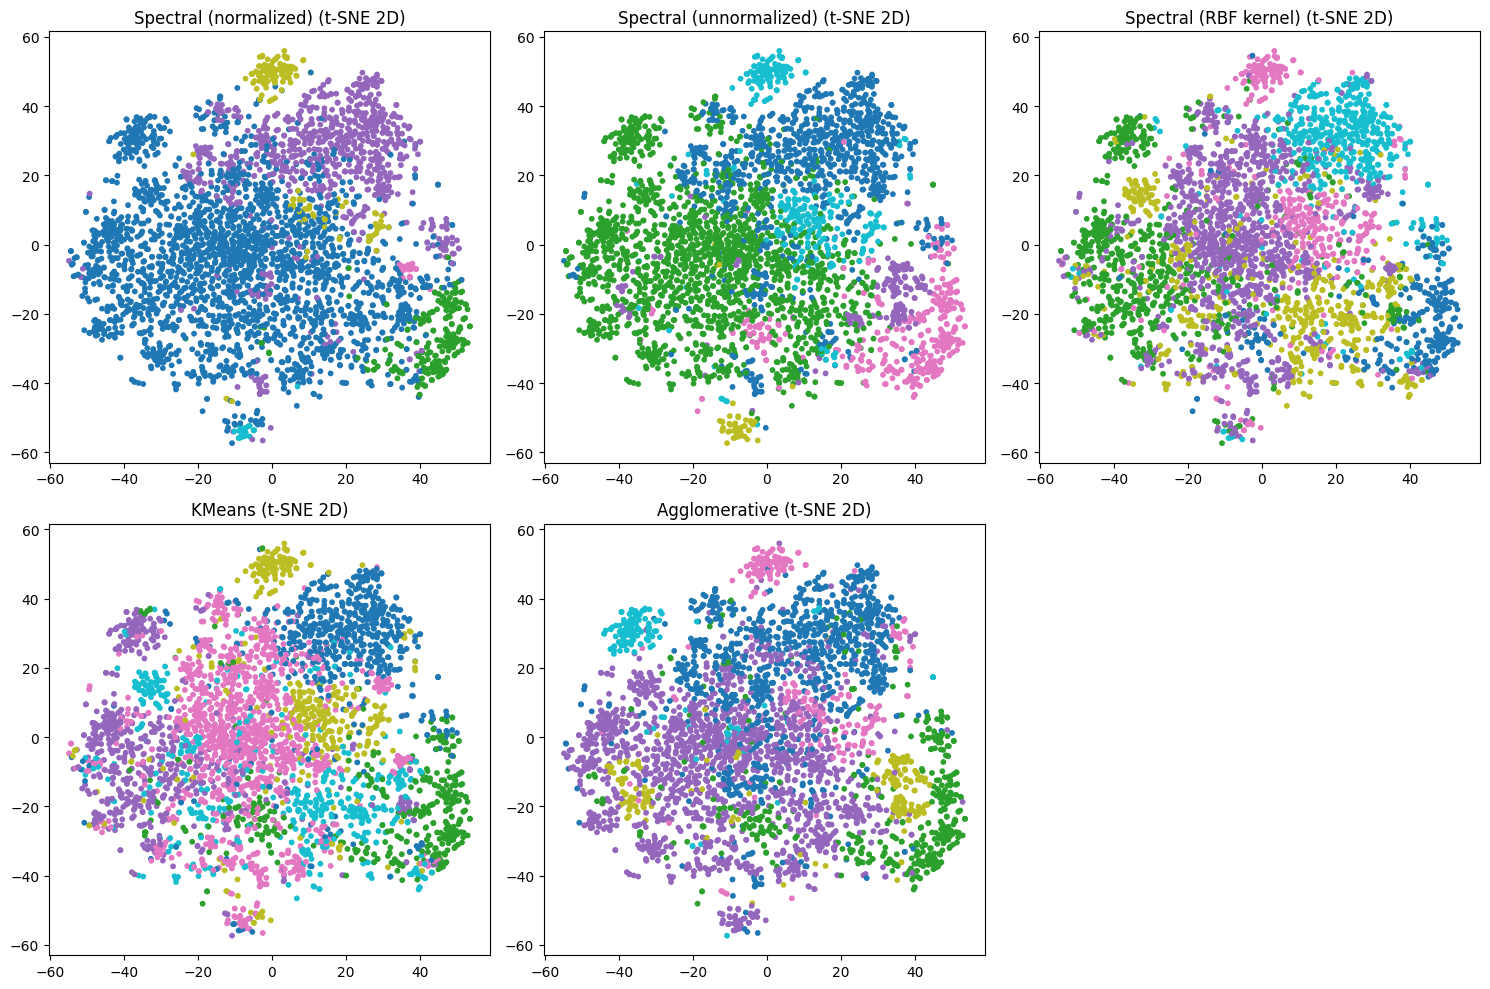

In [74]:
# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(15,10))
for i, (name, labels) in enumerate(methods_labels.items(), 1):
    plt.subplot(2,3,i)
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="tab10", s=10)
    plt.title(f"{name} (t-SNE 2D)")
plt.tight_layout()
plt.show()